In [1]:
import numpy as np
import matplotlib.pyplot as plt
import agama
from scipy.stats import binned_statistic
from scipy.interpolate import UnivariateSpline

In [2]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 16})

In [57]:
def compute_quantities(positions, velocities, nbins, G, R, r_min, r_max):
    s_smooth = 0.2
    
    # Compute radial distances of all particles
    radial_distances = np.linalg.norm(positions, axis=1)

    # Create logarithmically spaced bins and compute bin centers
    r_bins = np.logspace(np.log10(r_min), np.log10(r_max), nbins + 1)
    r_centers = 0.5 * (r_bins[1:] + r_bins[:-1])

    # Compute unit radial vectors for all particles
    unit_r = positions / radial_distances[:, np.newaxis]

    # Compute radial component of the velocity for all particles
    v_r = np.sum(velocities * unit_r, axis=1)

    # Compute binned statistics for radial and tangential velocity dispersions
    sigma_rr_squared, _, _ = binned_statistic(
        radial_distances, v_r**2, statistic='mean', bins=r_bins
    )

    # Compute tangential velocity components and dispersions
    v_tangent = velocities - (v_r[:, np.newaxis] * unit_r)
    v_t_squared = np.sum(v_tangent**2, axis=1)
    sigma_t_squared, _, _ = binned_statistic(
        radial_distances, v_t_squared, statistic='mean', bins=r_bins
    )

    # Compute density using particle counts and bin volumes
    particle_counts, _ = np.histogram(radial_distances, bins=r_bins)
    volumes = (4 / 3) * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3)
    rho_r = particle_counts / volumes

    # Apply spline smoothing 
    spline_rho_r = UnivariateSpline(np.log(r_centers), np.log(rho_r), s=s_smooth)  
    spline_sigma_rr_squared = UnivariateSpline(np.log(r_centers), np.log(sigma_rr_squared), s=s_smooth)
    spline_sigma_t_squared = UnivariateSpline(np.log(r_centers), np.log(sigma_t_squared), s=s_smooth)

    # Use the smoothed quantities
    smoothed_log_rho_r = spline_rho_r(np.log(r_centers))
    smoothed_log_sigma_rr_squared = spline_sigma_rr_squared(np.log(r_centers))
    smoothed_log_sigma_t_squared = spline_sigma_t_squared(np.log(r_centers))

    # Compute terms using smoothed quantities
    sigma2 = np.exp(smoothed_log_sigma_rr_squared) 
    term_r_sigma2_over_G = -r_centers * np.exp(smoothed_log_sigma_rr_squared) / G

    # Compute logarithmic slopes using derivatives from the splines
    dln_nu_dln_r = spline_rho_r.derivative()(np.log(r_centers))
    dln_sigma2_dln_r = spline_sigma_rr_squared.derivative()(np.log(r_centers))

    # Compute velocity anisotropy parameter beta(r) using smoothed sigma_t_squared
    beta_r_values = 1 - (np.exp(smoothed_log_sigma_t_squared) / 
                         (2 * np.exp(smoothed_log_sigma_rr_squared)))

    # Compute the combination of terms for the mass equation
    mass_combination = term_r_sigma2_over_G * (dln_nu_dln_r + dln_sigma2_dln_r + 2 * beta_r_values)
    mass_combination1 = term_r_sigma2_over_G * dln_nu_dln_r

    return r_centers, rho_r, sigma2, term_r_sigma2_over_G, dln_nu_dln_r, dln_sigma2_dln_r, beta_r_values, mass_combination, mass_combination1


In [49]:
# ----------------------------
# Parameters
# ----------------------------

# Number of particles
N = 30000

# Number of crossing times
N_cross = 200

# Number of time steps
number_of_times = 100

# Physical constants and parameters
M = 1.0              # Total mass of the Plummer sphere
R = 0.2              # Scale radius of the Plummer model
G = 1.0              # Gravitational constant (in units where G=1)

# Create the Plummer potential and density
pot_plummer_ini = agama.Potential(type='Plummer', mass=M, scaleradius=R)
den_plummer = agama.Density(type='Plummer', mass=M, scaleradius=R)

# Create the Distribution Function 
df = agama.DistributionFunction(
    type='QuasiSpherical',
    potential=pot_plummer_ini,
    density=den_plummer
)

# Create the AGAMA GalaxyModel for the Chosen Potential
model = agama.GalaxyModel(potential=pot_plummer_ini, df=df)

# Sample Initial Conditions
print("Sampling initial conditions...")
Nlarge = int(10*N)  # Sample a larger number for better statistics
samples_large, masses_large = model.sample(Nlarge)
# Randomly select N particles from the sampled data
indices = np.random.choice(Nlarge, size=N, replace=False)
samples = samples_large[indices]

# Extract positions and velocities
positions_ini = samples[:, :3]    # Shape: (N, 3)
velocities_ini = samples[:, 3:]   # Shape: (N, 3)


Sampling initial conditions...


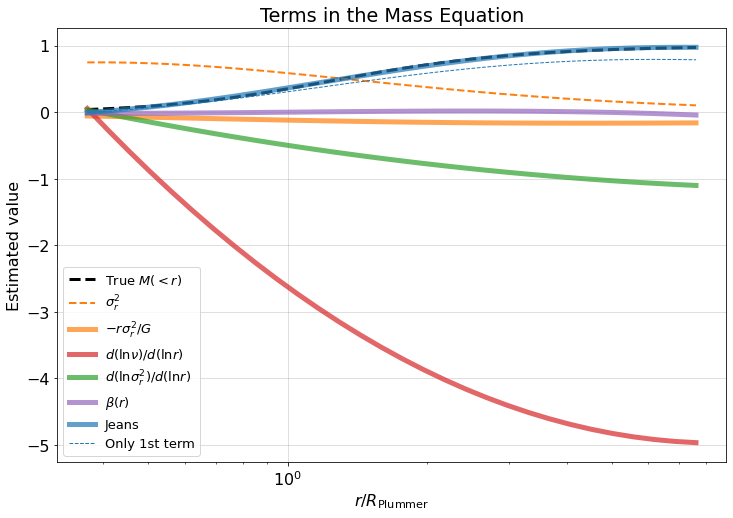

In [59]:
# Parameters
nbins = 30  # Number of bins

# Radial range
r_min = 7e-2
r_max = 8*R

positions = positions_ini
velocities = velocities_ini

r_centers, rho_r, sigma2, term_r_sigma2_over_G, dln_nu_dln_r, dln_sigma2_dln_r, beta_r_values, mass_combination, mass_combination1 = compute_quantities(positions, 
                                                                        velocities, nbins, G, R, r_min, r_max)

# Compute mass enclosed for each bin center
mass_enclosed = pot_plummer_ini.enclosedMass(r_centers)

# Plotting each term as a function of r
plt.figure(figsize=(12, 8))

plt.plot(r_centers/R, mass_enclosed, label=r'True $M(<r)$', color='black', linestyle='--',lw=3)
plt.plot(r_centers/R, sigma2, label=r'$\sigma_r^2$', color='tab:orange', lw=2,linestyle='--')
plt.plot(r_centers/R, term_r_sigma2_over_G, label=r'$-r\sigma_r^2 / G$', color='tab:orange', lw=5, 
         alpha=0.7)
plt.plot(r_centers/R, dln_nu_dln_r, label=r'$d(\ln\nu) / d(\ln r)$', color='tab:red', lw=5, alpha=0.7)
plt.plot(r_centers/R, dln_sigma2_dln_r, label=r'$d(\ln \sigma_r^2) / d(\ln r)$', color='tab:green', 
         lw=5, alpha=0.7)
plt.plot(r_centers/R, beta_r_values, label=r'$\beta(r)$', color='tab:purple', lw=5, alpha=0.7)
plt.plot(r_centers/R, mass_combination, label='Jeans', color='tab:blue', lw=5, alpha=0.7)
plt.plot(r_centers/R, mass_combination1, label='Only 1st term', color='tab:blue', lw=1, linestyle='--')

plt.xscale('log')
plt.xlabel(r'$r/R_{\rm Plummer}$')
plt.ylabel('Estimated value')
plt.title('Terms in the Mass Equation')
plt.legend(fontsize=13)
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

plt.savefig("../Figures/jeans_mass_enclosed.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()


In [51]:
# Function to update mass as a function of time
def mass_function(t, T):
     return M_initial + dM * (t / T)

# Mass evolution parameters
M_initial = M       # Initial mass of the Plummer sphere
dM = +0.5
number_of_times = 100 # Number of time steps

# Compute crossing time estimate to define integration time
v_mean = np.mean(np.linalg.norm(velocities_ini, axis=1))
t_cross = R / v_mean
T = 100 * t_cross
dt = T/number_of_times

# Initialize lists to store times, positions, and velocities
times_orbit = [0]  # Start with time 0
positions_all = [positions_ini]  # Initial positions
velocities_all = [velocities_ini]  # Initial velocities

# Integrate Orbits Using AGAMA's orbit Function with mass changing over time
print("Integrating orbits...")
for time_step in np.linspace(0, T, number_of_times)[1:]:

    # Update mass of the Plummer potential
    current_mass = mass_function(time_step, T)
    pot_plummer = agama.Potential(type='Plummer', mass=current_mass, scaleradius=R)
    
    # Use the positions and velocities from the last step as initial conditions
    ic = np.hstack((positions_all[-1], velocities_all[-1]))

    # Integrate orbits for this time step
    orbit = agama.orbit(
        potential=pot_plummer,
        ic=ic,
        time=dt,  
        trajsize=1,
        dtype='f8'
    )

    # Extract the time for this step (same for all particles)
    times_orbit.append(times_orbit[-1] + dt)  # Increment time

    # Extract positions and velocities for all particles at this time step
    trajectories = orbit[:, 1]  # Shape: (N, 6)
    positions = np.squeeze(np.array([trajectory[:, :3] for trajectory in trajectories]), axis=1)
    velocities = np.squeeze(np.array([trajectory[:, 3:] for trajectory in trajectories]), axis=1)

    # Append positions and velocities to the lists
    positions_all.append(positions)
    velocities_all.append(velocities)

print("Orbit integration completed.")

# Convert lists to NumPy arrays
times_orbit = np.array(times_orbit)  # Shape: (number_of_times,)
positions_all = np.array(positions_all)  # Shape: (number_of_times, N, 3)
velocities_all = np.array(velocities_all)  # Shape: (number_of_times, N, 3)

# Compute radial distances of each particle at each time step
radial_distances = np.linalg.norm(positions_all, axis=2)

# Compute the extent of the system as the standard deviation of radial distances at each time step
system_size = np.std(radial_distances, axis=1)

Integrating orbits...
Orbit integration completed.


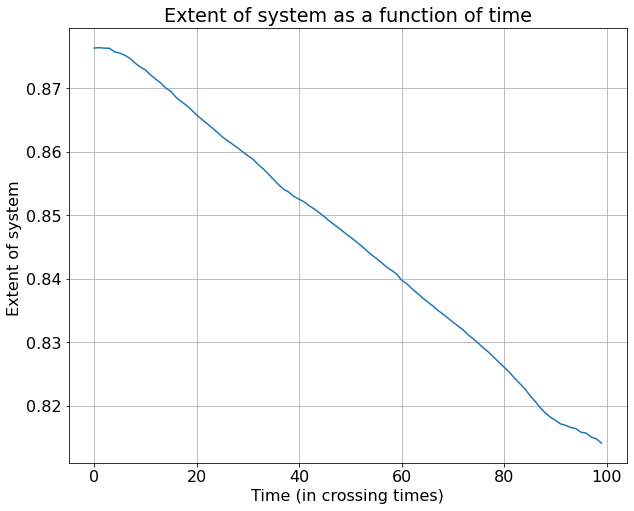

In [52]:
# Plotting each term as a function of r
plt.figure(figsize=(10, 8))

plt.plot(times_orbit/t_cross, system_size)
plt.xlabel('Time (in crossing times)')
plt.ylabel('Extent of system ')
plt.title('Extent of system as a function of time')
plt.grid(True)
plt.show()

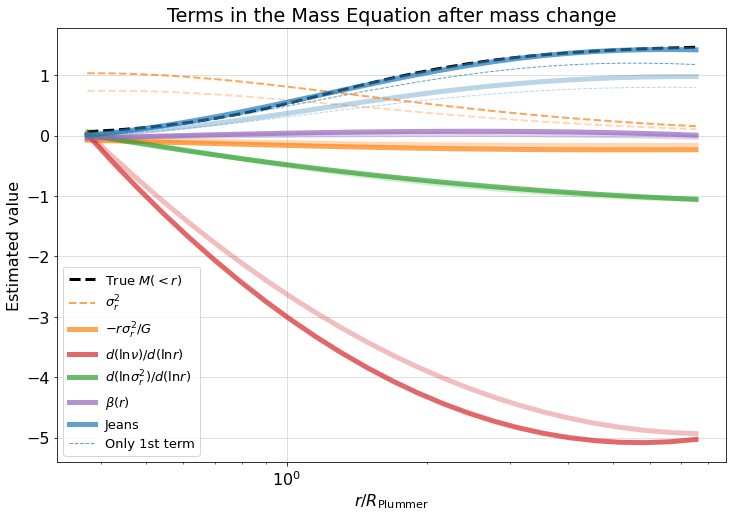

In [70]:
#  Parameters
nbins = 25  # Number of bins

positions = positions_ini
velocities = velocities_ini

r_centers, rho_r, sigma2, term_r_sigma2_over_G, dln_nu_dln_r, dln_sigma2_dln_r, beta_r_values, mass_combination, mass_combination1 = compute_quantities(positions, 
                                                                        velocities, nbins, G, R, r_min, r_max)

# Compute mass enclosed for each bin center
mass_enclosed = pot_plummer.enclosedMass(r_centers)

# Plotting each term as a function of r
plt.figure(figsize=(12, 8))

plt.plot(r_centers/R, mass_enclosed, color='black', linestyle='--',lw=3, label=r'True $M(<r)$')
plt.plot(r_centers/R, sigma2, color='tab:orange', lw=2,linestyle='--', alpha=0.3)
plt.plot(r_centers/R, term_r_sigma2_over_G, color='tab:orange', lw=5, alpha=0.3)
plt.plot(r_centers/R, dln_nu_dln_r, color='tab:red', lw=5, alpha=0.3)
plt.plot(r_centers/R, dln_sigma2_dln_r, color='tab:green', lw=5, alpha=0.2)
plt.plot(r_centers/R, beta_r_values, color='tab:purple', lw=5, alpha=0.3)
plt.plot(r_centers/R, mass_combination, color='tab:blue', lw=5, alpha=0.3)
plt.plot(r_centers/R, mass_combination1, color='tab:blue', lw=1, linestyle='--', alpha=0.3)

ind = 99
positions = np.squeeze(positions_all[ind, :, :])
velocities = np.squeeze(velocities_all[ind, :, :])

r_centers, rho_r2, sigma2_2, term_r_sigma2_over_G, dln_nu_dln_r, dln_sigma2_dln_r, beta_r_values, mass_combination, mass_combination1 = compute_quantities(positions, 
                                                                        velocities, nbins, G, R, r_min, r_max)

ind0 = 0
plt.plot((r_centers/R)[ind0:], sigma2_2[ind0:], label=r'$\sigma_r^2$', color='tab:orange', 
         lw=2,linestyle='--', alpha=0.7)
plt.plot((r_centers/R)[ind0:], term_r_sigma2_over_G[ind0:], label=r'$-r\sigma_r^2 / G$', 
         color='tab:orange', lw=5, alpha=0.7)
plt.plot((r_centers/R)[ind0:], dln_nu_dln_r[ind0:], label=r'$d(\ln\nu) / d(\ln r)$', color='tab:red', 
         lw=5, alpha=0.7)
plt.plot((r_centers/R)[ind0:], dln_sigma2_dln_r[ind0:], label=r'$d(\ln \sigma_r^2) / d(\ln r)$', 
         color='tab:green', lw=5, alpha=0.7)
plt.plot((r_centers/R)[ind0:], beta_r_values[ind0:], label=r'$\beta(r)$', color='tab:purple', lw=5, 
         alpha=0.7)
plt.plot((r_centers/R)[ind0:], mass_combination[ind0:], label='Jeans', color='tab:blue', lw=5, 
         alpha=0.7)
plt.plot((r_centers/R)[ind0:], mass_combination1[ind0:], label='Only 1st term', color='tab:blue', 
         lw=1, linestyle='--', alpha=0.7)

plt.xscale('log')
plt.xlabel(r'$r/R_{\rm Plummer}$')
plt.ylabel('Estimated value')
plt.title('Terms in the Mass Equation after mass change')
plt.legend(fontsize=13)
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

plt.savefig("../Figures/jeans_mass_enclosed_evolved.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()

In [ ]:
# Plotting density as a function of r
plt.figure(figsize=(12, 8))

plt.plot((r_centers/R)[ind0:],rho_r[ind0:], color='black', lw=5,alpha=0.3)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$r/R_{\rm Plummer}$')
plt.ylabel('Density')
plt.title('Density vs radius')
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

plt.savefig("../Figures/jeans_mass_density.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()

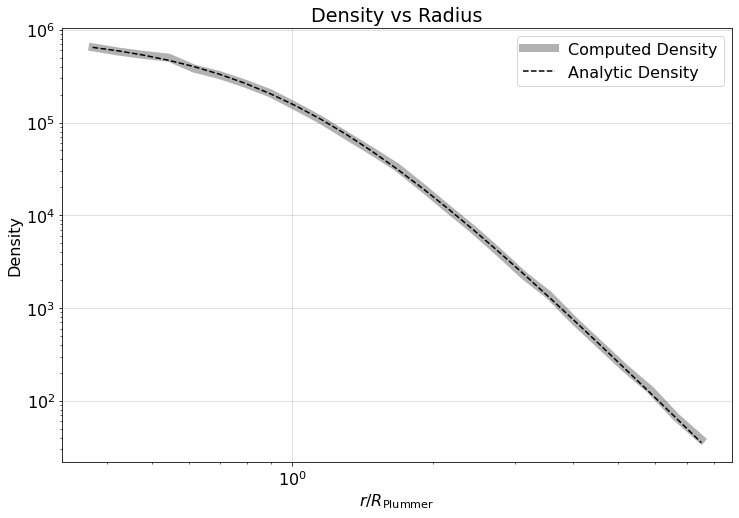

In [69]:
# Assuming `pot_plummer` is already defined and `N` is the number of particles
# Example: pot_plummer = agama.Potential(type='Plummer', mass=1.0, scaleradius=R)

# Generate analytical density for the Plummer model, rescaled for the total number of particles
analytic_r = r_centers[ind0:] / R  # Normalized radius values
analytic_density = [
    pot_plummer_ini.density([r * R, 0, 0]) * (N / pot_plummer_ini.totalMass()) for r in analytic_r
]  # Rescale density by particle count

# Plotting density as a function of r
plt.figure(figsize=(12, 8))

# Plot the computed density
plt.plot((r_centers / R)[ind0:], rho_r[ind0:], color='black', lw=8, alpha=0.3, label='Computed Density')

# Overplot the analytical density, rescaled
plt.plot((r_centers / R)[ind0:], analytic_density, linestyle='--', color='black', 
         label='Analytic Density')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$r/R_{\rm Plummer}$')
plt.ylabel('Density')
plt.title('Density vs Radius')
plt.legend()
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

plt.savefig("../Figures/jeans_mass_density.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()


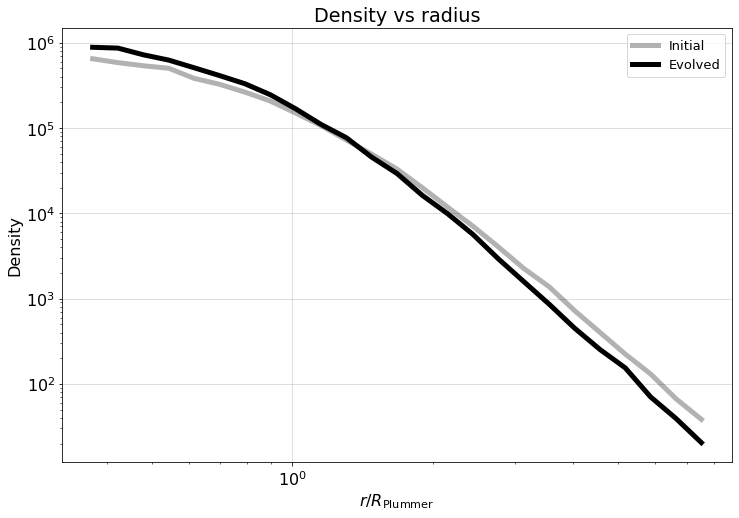

In [55]:
# Plotting density as a function of r
plt.figure(figsize=(12, 8))

plt.plot((r_centers/R)[ind0:],rho_r[ind0:], label='Initial', color='black', lw=5,alpha=0.3)

plt.plot((r_centers/R)[ind0:],rho_r2[ind0:], label='Evolved', color='black', lw=5,alpha=1)

plt.xscale('log')
plt.yscale('log')

plt.legend(fontsize=13)
plt.xlabel(r'$r/R_{\rm Plummer}$')
plt.ylabel('Density')
plt.title('Density vs radius')
plt.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

plt.savefig("../Figures/jeans_mass_density_evolution.png", format="png", 
            dpi=300, transparent=False, facecolor='white', bbox_inches='tight')

plt.show()